In [6]:
#import packages
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np
import lightgbm as lgb

In [7]:
#import train/test data and extract X/Y
train_data = pd.read_csv('./train_noclean_prices.csv')
test_data = pd.read_csv('./test_noclean_prices.csv')

y_train = train_data.loc[:,'price']
train_data = train_data.drop(columns='price')
num_features = len(train_data.columns)
features = list(train_data.columns[2:num_features])
X_train = train_data.loc[:,features]

features = list(test_data.columns[2:num_features])

X_test = test_data.loc[:,features]
test_labels = test_data.loc[:,'id']

test_labels = test_labels.to_frame()

In [9]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

kf = KFold(n_splits = 10, shuffle=True)

#run random grid search with k fold estimator and parallel processing

X = np.concatenate([X_train], axis= 0)
y = np.concatenate([y_train], axis= 0)
param_grid = {
    'n_estimators': [100, 500, 1000, 1500],
    'colsample_bytree': [0.7, 0.8],
    'max_depth': [10, 15,20,25],
    'num_leaves': [10, 20, 30, 40, 50],
    'reg_lambda': [0.2, 0.5, 0.8, 1, 1.1],
    'reg_alpha' : [0.2, 0.5, 0.8, 1, 1.1], 
    'min_split_gain': [0.3, 0.4],
    'subsample': [0.7, 0.8, 0.9],
    'subsample_freq': [20], 
    'min_data_in_leaf': [15, 25, 30, 40],
    'learning_rate': [0.01, 0.05, 0.1, 0.15]
}
lgb_estimator = lgb.LGBMClassifier(boosting_type='gbdt',  objective='multiclass', metric='multi_error')
rsearch = RandomizedSearchCV(estimator=lgb_estimator, param_distributions=param_grid, cv=kf, n_iter = 1000, n_jobs = -1, verbose=10)
lgb_model = rsearch.fit(X=X, y=y)


print(lgb_model.best_params_, lgb_model.best_score_)


Fitting 10 folds for each of 1000 candidates, totalling 10000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   31.6s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   39.2s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   58.8s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 113 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 149 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 189 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 210 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 233 tasks      | elapsed:  

[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
{'subsample_freq': 20, 'subsample': 0.8, 'reg_lambda': 0.8, 'reg_alpha': 0.5, 'num_leaves': 30, 'n_estimators': 1500, 'min_split_gain': 0.3, 'min_data_in_leaf': 15, 'max_depth': 20, 'learning_rate': 0.01, 'colsample_bytree': 0.8} 0.5591362186457881


In [10]:
print(lgb_model.best_params_, lgb_model.best_score_)
#THIS IS FOR THE RANDOM SEARCH
#print parameters

{'subsample_freq': 20, 'subsample': 0.8, 'reg_lambda': 0.8, 'reg_alpha': 0.5, 'num_leaves': 30, 'n_estimators': 1500, 'min_split_gain': 0.3, 'min_data_in_leaf': 15, 'max_depth': 20, 'learning_rate': 0.01, 'colsample_bytree': 0.8} 0.5591362186457881


In [11]:
#run model again and print CV scores 
from sklearn.metrics import accuracy_score
import lightgbm as lgb
kf = KFold(n_splits = 10, shuffle=True)


X = np.concatenate([X_train], axis= 0)
y = np.concatenate([y_train], axis= 0)

for train, test in kf.split(X_train):
    X_train_kf, X_test_kf = X[train],X[test]
    y_train_kf, y_test_kf = y[train],y[test]
    d_train=lgb.Dataset(X_train_kf, label=y_train_kf)
    best_param = {'verbose':-1,'boosting_type':'gbdt',  'objective':'multiclass', 'num_class':5, 'metric':'multi_error','subsample_freq': 20, 'subsample': 0.8, 'reg_lambda': 0.8, 'reg_alpha': 0.5, 'num_leaves': 30, 'n_estimators': 1500, 'min_split_gain': 0.3, 'min_data_in_leaf': 15, 'max_depth': 20, 'learning_rate': 0.01, 'colsample_bytree': 0.8}
    clf=lgb.train(best_param,d_train )
    
    y_pred=clf.predict(X_test_kf)
    y_pred = [np.argmax(line) for line in y_pred]
    print(accuracy_score(y_test_kf, y_pred))

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


0.5737874097007224
0.5340909090909091
0.5568181818181818
0.5702479338842975
0.5609504132231405
0.5433884297520661
0.5475206611570248
0.5578512396694215
0.5650826446280992
0.5206611570247934


In [12]:
#run final model with "best_param" as parameters and entire train set
X = np.concatenate([X_train], axis= 0)
y = np.concatenate([y_train], axis= 0)
best_param = {'verbose':-1,'boosting_type':'gbdt',  'objective':'multiclass', 'num_class':5, 'metric':'multi_error','subsample_freq': 20, 'subsample': 0.8, 'reg_lambda': 0.8, 'reg_alpha': 0.5, 'num_leaves': 30, 'n_estimators': 1500, 'min_split_gain': 0.3, 'min_data_in_leaf': 15, 'max_depth': 20, 'learning_rate': 0.01, 'colsample_bytree': 0.8}

best_param1 = {'boosting_type':'gbdt',  'objective':'multiclass', 'learning_rate':0.01, 'num_class':5, 'metric':'multi_error','subsample_freq': 20, 'subsample': 0.8, 'reg_lambda': 1.2, 'num_leaves': 40, 'n_estimators': 1000, 'min_split_gain': 0.4, 'min_data_in_leaf': 25, 'max_depth': 20, 'colsample_bytree': 0.7}
d_train=lgb.Dataset(X, y)
clf=lgb.train(best_param,d_train)

In [13]:
y_pred1=clf.predict(X)
#print training accuracy 
y_pred1 = [np.argmax(line) for line in y_pred1]
print(accuracy_score(y, y_pred1))

0.8595186447681025


In [14]:
#predict on test set
y_pred=clf.predict(X_test)

In [15]:

print(y_pred)

[[1.10620062e-15 1.47085792e-01 5.45827415e-01 2.32050743e-01
  7.50360502e-02]
 [1.00248840e-15 7.95201380e-02 3.27910022e-01 4.81130244e-01
  1.11439596e-01]
 [8.74255484e-16 3.07506383e-01 3.98789149e-01 2.39330589e-01
  5.43738790e-02]
 ...
 [9.69328543e-16 6.52846697e-02 2.20550942e-01 4.42970529e-01
  2.71193860e-01]
 [3.40972928e-16 9.18490803e-01 4.12302714e-02 2.99197712e-02
  1.03591548e-02]
 [1.28477150e-15 1.29044209e-01 4.46131952e-01 2.85289333e-01
  1.39534506e-01]]


In [16]:
y_pred = [np.argmax(line) for line in y_pred]

In [18]:
#add to dataframe
df = pd.DataFrame
test_labels['price'] = y_pred

test_labels['price'] = test_labels['price'].map(lambda x: int(x))

In [19]:
test_labels

,id,price
0,7715,2
1,13196,3
2,13194,2
3,4673,2
4,11325,1
...,...,...
4144,12921,2
4145,7174,1
4146,9240,3
4147,11663,1


In [20]:
#convert to csv
test_labels.to_csv(r'./submission17.csv', index=False)

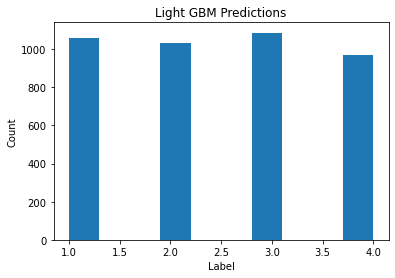

In [1]:
#print histogram 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
labels = pd.read_csv('./submission7.csv')
y_pred = labels.loc[:,'price']
plt.figure()
plt.hist(y_pred)
plt.title("Light GBM Predictions")
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()